# **User guide: using lynx-id**

The purpose of this notebook is to show how to use lynx_id.

**Before starting this guide, make sure you have installed lynx_id**.

*The next cell automatically reloads the libraries if they are updated. This is only useful for debugging purposes.*

In [1]:
# Allow reloading of libraries without restarting the kernel
%load_ext autoreload
%autoreload 2

First, a few imports needed for the demo.

In [2]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

from safetensors import safe_open
from safetensors.torch import save_file
from pathlib import Path
from PIL import Image

In [3]:
print(f"Updated on {datetime.datetime.now().date()}.")

Updated on 2024-05-06.


## **Resources**

What resources do we have? GPU (cuda) or CPU?

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{DEVICE=}")

DEVICE='cuda'


Initialize a path to the demo resources.

In [5]:
RESOURCES = Path("../../../lynx_id/resources")

## **Knowledge base**

To predict the individuals in our new images, we need to have a knowledge base.

This requires **2 files**:

1. a file in **csv** format containing information about our individuals (`lynx_id`, `filepath`, `location`, `date`)
2. a file in **safetensors** format containing the embeddings of our individuals. This file is necessary for the algorithms behind it.

For an index in the embedding matrix, the same index in the csv file provides the associated information.

Let's see what it looks like. First, we open the information file in csv format.

In [6]:
knowledge_informations = pd.read_csv(RESOURCES/ "knowledge_db/informations.csv")
print(knowledge_informations.shape)
knowledge_informations.head()

(8281, 4)


,filepath,lynx_id,date,location
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,B500_Patrik,NaN,NaN
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,F01-016,2014-03-04,Peyrieu
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,B500_Patrik,NaN,NaN
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,B38_Stefan,NaN,NaN
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,1350=B2011-57,2020-01-22,Neuwiller-Les-Saverne


In [7]:
with safe_open(RESOURCES / "knowledge_db/embeddings.safetensors", framework="pt", device="cpu") as f:
    knowledge_embeddings = f.get_tensor("embeddings")
knowledge_embeddings.shape

torch.Size([8281, 2048])

In [8]:
assert knowledge_embeddings.shape[0] == knowledge_informations.shape[0]

Our two files are the same size (same number of images). 

## **Individual prediction**

### **Image display**

We're going to start with a folder containing 2 images.

In [9]:
folder_images = RESOURCES / "data"

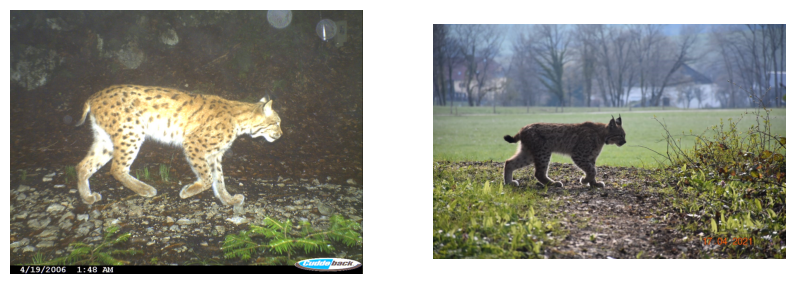

In [10]:
images = os.listdir(folder_images)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

img1 = Image.open(os.path.join(folder_images, images[0]))
axes[0].imshow(img1)
axes[0].axis('off')

img2 = Image.open(os.path.join(folder_images, images[1]))
axes[1].imshow(img2)
axes[1].axis('off')

plt.show()

### **Inference script**

We're going to give our images to our individual recognition model.

To do this, a configuration file (`yaml`) must be initialized. It should contain the following parameters:

- `model-path`: path to the embeddings model
- `input-data`: path to the folder containing the images, or a `csv` file containing at least a `filepath` column indicating where the images are located
- `output-informations-path`: output file (`csv`) containing information after prediction. Its content is presented later in the notebook.
- `output-embeddings-path`: output files containing information after prediction. This file will allow us to update our embeddings database containing all our images.
- `knowledge-informations-path`: this file (`csv`) contains information on all the images in our knowledge base. The information stored are:
  - `filepath`: path to current image
  - `lynx_id`: individual on the image
  - `location`: place where the photo was taken
  - `date`: date on which the photo was taken
- `knowledge-embeddings-path`: this file (`safetensors`) contains embeddings on all the images in our knowledge base. These embeddings are used to detect the individual closest to the current image or to detect a new individual.
- `threshold`: if the distance of the individual closest to our image is greater than `threshold` then we consider it to be a new individual. Default value: 1.4
- `batch-size`: number of images to load per batch during inference. A large number will enable inference to proceed faster but could saturate your memory and cause the inference to crash.
- `num-workers`: how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process.

This file is initialized with resources located in `lynx_id/resources`. Only the model is not included. It must be retrieved in another way.

In [11]:
%%writefile config_infer.yaml
model-path: ../../../lynx_id/resources/downloaded_model/model_best_0.512.pth
input-data: ../../../lynx_id/resources/data
output-informations-path: ../../../lynx_id/resources/results/result_informations.csv
output-embeddings-path: ../../../lynx_id/resources/results/result_embeddings.safetensors
knowledge-informations-path: ../../../lynx_id/resources/knowledge_db/informations.csv
knowledge-embeddings-path: ../../../lynx_id/resources/knowledge_db/embeddings.safetensors
threshold: 0.5  # default value is 1.4. The value has been set to 0.5 to detect a new individual.
batch-size: 1
num-workers: 1

Overwriting config_infer.yaml


We can then simply run our inference script.

In [12]:
!python -m lynx_id infer --config config_infer.yaml

This is the infer script.
DEVICE='cuda'
Compute embeddings: 100%|█████████████████████████| 2/2 [00:01<00:00,  1.41it/s]
End of inference.


Let's look at the information result file generated.

In [13]:
results_csv = pd.read_csv(RESOURCES / "results/result_informations.csv")
results_csv

,filepath,individual_predicted,is_new,latest_picture_individual_predicted,location_closest_individual,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5
0,../../../lynx_id/resources/data/B439_OCS_NA_20...,B439,False,2020-04-28,NaN,B439,F39-060,B583_Kassandra,B11_Kika_Silva_Juv.08,B224_Nora
1,../../../lynx_id/resources/data/2327_OFB_OCELL...,8Ugen8heuy,True,NaN,NaN,New,409,2125,2125,B287_Moritz


The file generated contains the following information:
- `filepath`: path to the processed image.
- `individual_predicted`: predicted individual. For new individuals detected, a random character string of 10 characters is generated.
- `is_new`: indicates whether it is a new individual or not. We can imagine cases where the `individual_predicted` generated is similar to a human name.
- `latest_picture_individual_predicted`: for the predicted individual (and not just the nearest image), the last date on which a photo was taken of him or her in our knowledge base.
- `location_closest_individual`: where the photo of the nearest image was taken
- `neighbor_[12345]`: the 5 closest individuals

Once the result file has been created, the user can then modify the information that will be saved in the knowledge base (`filepath`, `individual_predicted`, `location`, `date`). They can also add a location and date to each image.
To do the whole thing in a notebook, we modify the `csv` directly with `pandas` but a simple text editor could suffice to do the same.

Here, we rename the individual in the index 1 image and add a location to it.

In [14]:
results_csv.loc[1, 'individual_predicted'] = "Goat"
results_csv.loc[1, 'location'] = "Paris"
results_csv

,filepath,individual_predicted,is_new,latest_picture_individual_predicted,location_closest_individual,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,location
0,../../../lynx_id/resources/data/B439_OCS_NA_20...,B439,False,2020-04-28,NaN,B439,F39-060,B583_Kassandra,B11_Kika_Silva_Juv.08,B224_Nora,nan
1,../../../lynx_id/resources/data/2327_OFB_OCELL...,Goat,True,NaN,NaN,New,409,2125,2125,B287_Moritz,Paris


The updated file is saved.

In [15]:
results_csv.to_csv(RESOURCES / "results/result_informations.csv", index=False)

Following inference, an embedding file was also generated for our images.

In [16]:
with safe_open(RESOURCES / "results/result_embeddings.safetensors", framework="pt", device="cpu") as f:
    results_embeddings = f.get_tensor("embeddings")
results_embeddings.shape

torch.Size([2, 2048])

We have a matrix of size [2, 2048]. We have 2 embeddings, one per image, and our embeddings are of size 2048; a size that depends on the model used.

## **Update knowledge base**

Now we have our results, and we've even modified them a little to include some additional information. We can now update our knowledge base using the `knowledge_base` script. As with the inference script, a configuration file is required. Here are the parameters to be entered:

- `knowledge-informations-path`: as in the inference script. This file (`csv`) contains information on all the images in our knowledge base.
- `knowledge-embeddings-path`: as in the inference script. This file (`safetensors`) contains embeddings on all the images in our knowledge base.
- `updated-informations-path`: path to results containing information about images in the inference script (`csv` file)
- `updated-embeddings-path`: path to results containing embeddings about images in the inference script (`csv` file)
- `new-knowledge-informations-path`: path to the updated information knowledge base (`csv`). If not filled in, the file is written over the current base (`knowledge-informations-path`).
- `new-knowledge-embeddings-path`: path to the updated information knowledge base (`safetensors`). If not filled in, the file is written over the current base (`knowledge-embeddings-path`).

Let's initialize this file with our data.

In [17]:
%%writefile config_knowledge_base.yaml
knowledge-informations-path: ../../../lynx_id/resources/knowledge_db/informations.csv
knowledge-embeddings-path: ../../../lynx_id/resources/knowledge_db/embeddings.safetensors
updated-informations-path: ../../../lynx_id/resources/results/result_informations.csv
updated-embeddings-path: ../../../lynx_id/resources/results/result_embeddings.safetensors
new-knowledge-informations-path: ../../../lynx_id/resources/knowledge_db/new_informations.csv
new-knowledge-embeddings-path: ../../../lynx_id/resources/knowledge_db/new_embeddings.safetensors

Overwriting config_knowledge_base.yaml


We simply run the `knowledge_base` script with this file passed as a parameter.

In [18]:
!python -m lynx_id knowledge_base --config config_knowledge_base.yaml

This is the knowledge_base script.
End of knowledge_base script.


In [19]:
updated_knowledge_informations = pd.read_csv(RESOURCES / "knowledge_db/new_informations.csv")
updated_knowledge_informations.shape

(8283, 4)

Two lines have been added to our knowledge base corresponding to our 2 previous images. Here are their contents:

In [20]:
updated_knowledge_informations.tail(2)

,filepath,lynx_id,date,location
8281,../../../lynx_id/resources/data/B439_OCS_NA_20...,B439,NaN,NaN
8282,../../../lynx_id/resources/data/2327_OFB_OCELL...,Goat,NaN,Paris


Another case involves modifying the information and embeddings of an image. In this case, we don't want to add any lines to our knowledge base.

Let's modify the line in our first image.

In [21]:
new_results_csv = pd.DataFrame(results_csv.iloc[0]).T
new_results_csv.loc[0, "location"] = "Annecy"
new_results_csv.loc[0, "date"] = datetime.date.today()
new_results_csv

,filepath,individual_predicted,is_new,latest_picture_individual_predicted,location_closest_individual,neighbor_1,neighbor_2,neighbor_3,neighbor_4,neighbor_5,location,date
0,../../../lynx_id/resources/data/B439_OCS_NA_20...,B439,False,2020-04-28,NaN,B439,F39-060,B583_Kassandra,B11_Kika_Silva_Juv.08,B224_Nora,Annecy,2024-05-06


The associated embedding is also modified. This can be useful if you want to use a different embedding model, for example.

In [22]:
new_results_embeddings = torch.zeros((1, 2048))
new_results_embeddings

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

Save changes.

In [23]:
new_results_csv.to_csv(RESOURCES / "results/result_informations.csv", index=False)
save_file({"embeddings": new_results_embeddings}, RESOURCES / "results/result_embeddings.safetensors")

We can now re-run our knowledge base update script.

In [24]:
%%writefile config_knowledge_base.yaml
knowledge-informations-path: ../../../lynx_id/resources/knowledge_db/new_informations.csv
knowledge-embeddings-path: ../../../lynx_id/resources/knowledge_db/new_embeddings.safetensors
updated-informations-path: ../../../lynx_id/resources/results/result_informations.csv
updated-embeddings-path: ../../../lynx_id/resources/results/result_embeddings.safetensors
new-knowledge-informations-path: ../../../lynx_id/resources/knowledge_db/new_informations_final.csv
new-knowledge-embeddings-path: ../../../lynx_id/resources/knowledge_db/new_embeddings_final.safetensors

Overwriting config_knowledge_base.yaml


In [25]:
!python -m lynx_id knowledge_base --config config_knowledge_base.yaml

This is the knowledge_base script.
End of knowledge_base script.


We look at the updated generated information file. 

In [26]:
final_informations = pd.read_csv(RESOURCES / "knowledge_db/new_informations_final.csv")
final_informations.tail(2)

,filepath,lynx_id,date,location
8281,../../../lynx_id/resources/data/B439_OCS_NA_20...,B439,2024-05-06,Annecy
8282,../../../lynx_id/resources/data/2327_OFB_OCELL...,Goat,NaN,Paris


We do the same for embeddings.

In [27]:
with safe_open(RESOURCES / "knowledge_db/new_embeddings_final.safetensors", framework="pt", device="cpu") as f:
    final_embeddings = f.get_tensor("embeddings")
final_embeddings.shape

torch.Size([8283, 2048])

In [28]:
final_embeddings[-2:]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1398, 0.2152, 0.1391,  ..., 0.0992, 0.1580, 0.1180]])

The embeddings and information have been updated without adding new elements to our knowledge base.